In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from ForwardContracts import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 8192  # number of trajectories (batch size)
N = 200 # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [21] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2*10**4
lr = 1e-3

In [4]:
model.load_model("models/Forward1D.pth")

In [5]:
graph = model.iteration, model.training_loss

In [191]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 9.957e-01, Y0: 0.358, Time: 0.01, Learning Rate: 1.000e-03
It: 100, Loss: 1.264e-03, Y0: -0.011, Time: 0.52, Learning Rate: 1.000e-03
It: 200, Loss: 6.580e-03, Y0: -0.013, Time: 0.51, Learning Rate: 1.000e-03
It: 300, Loss: 1.769e-03, Y0: -0.004, Time: 0.52, Learning Rate: 1.000e-03
It: 400, Loss: 2.133e-04, Y0: -0.000, Time: 0.54, Learning Rate: 1.000e-03
It: 500, Loss: 9.085e-04, Y0: 0.001, Time: 0.53, Learning Rate: 1.000e-03
It: 600, Loss: 4.732e-04, Y0: 0.000, Time: 0.52, Learning Rate: 1.000e-03
It: 700, Loss: 3.392e-03, Y0: 0.004, Time: 0.53, Learning Rate: 1.000e-03
It: 800, Loss: 4.471e-04, Y0: 0.005, Time: 0.53, Learning Rate: 1.000e-03
It: 900, Loss: 3.431e-04, Y0: 0.006, Time: 0.52, Learning Rate: 1.000e-03
It: 1000, Loss: 6.265e-05, Y0: 0.002, Time: 0.52, Learning Rate: 1.000e-03
It: 1100, Loss: 1.797e-04, Y0: -0.003, Time: 0.53, Learning Rate: 1.000e-03
It: 1200, Loss: 1.190e-05, Y0: -0.001, Time: 0.55, Learning Rate: 1.000e-03
It: 1300, Loss: 4.477e-0

In [6]:
np.random.seed(37)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

In [7]:
X_pred = X_pred[:500,:]

In [8]:
X_preds = X_pred[:,:,0]

In [9]:
def forward_price(S, K, T, r, q=0):
    forward_price = S * np.exp((r - q) * T) - K
    return forward_price

def calculate_forward_prices(X_pred, time_array, K, r, T, q=0):
    rows, cols = X_pred.shape
    forward_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            forward_prices[i, j] = forward_price(S, K, time_to_maturity, r, q)
    
    return forward_prices

# Given parameters
K = 1.0     # Strike price
r = 0.0    # Risk-free interest rate
q = 0       # Dividend yield (assuming none)
T = 1       # Expiry time in years

Y_test = calculate_forward_prices(X_preds, t_test[0], K, r, T, q)

/tmp/ipykernel_3134838/143983613.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_prices[i, j] = forward_price(S, K, time_to_maturity, r, q)


In [10]:
errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

(1.9634745486832652e-07, 2.9965280396889247e-07)

In [11]:
np.sqrt(errors.mean())

0.00044311110894258395

In [12]:
def figsize(scale, nplots = 1):
    fig_width_pt = 438.17227                        
    inches_per_pt = 1.0/72.27                       
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale    
    fig_height = nplots*fig_width*golden_mean             
    fig_size = [fig_width,fig_height]
    return fig_size

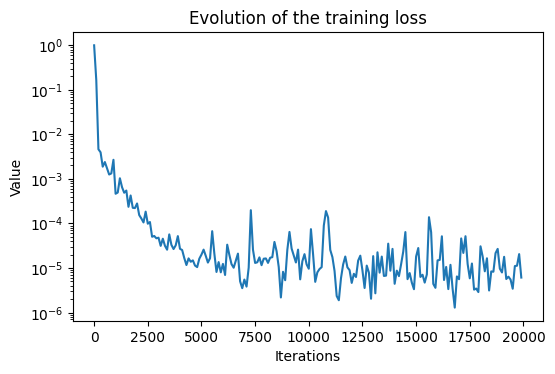

In [13]:
plt.figure(figsize=figsize(1.0))
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.savefig('Figures/Forward1D_loss.pdf')
plt.show()

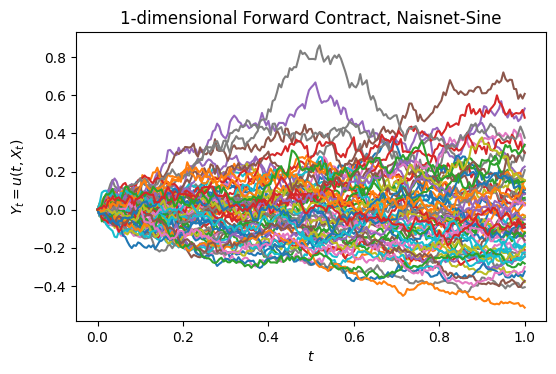

In [14]:
samples = 64

plt.figure(figsize=figsize(1.0))
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T)


plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Forward Contract, ' + model.mode + "-" + model.activation)
plt.savefig('Figures/Forward1D.pdf')
plt.show()

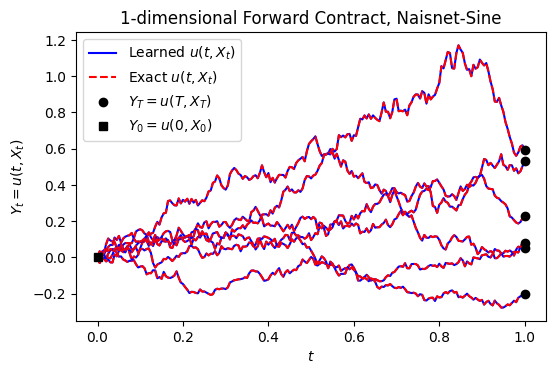

In [15]:
plt.figure(figsize=figsize(1.0))
plt.plot(t_test[0], Y_pred[0], 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0], Y_test[0], 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0, -1], Y_test[0, -1], 'ko', label='$Y_T = u(T,X_T)$')
for i in range(4, 100, 20):
    plt.plot(t_test[i], Y_pred[i], 'b')
    plt.plot(t_test[i], Y_test[i], 'r--')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko')
plt.plot([0], Y_test[0,0], 'ks', label='$Y_0 = u(0,X_0)$')
plt.title(str(D) + '-dimensional Forward Contract, ' + model.mode + "-" + model.activation)
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.legend()
plt.savefig('Figures/Forward1D_preds.pdf')
plt.show()

In [16]:
X_preds = np.sum(X_pred, axis=2) - 1
X_preds.shape

(500, 201)

In [17]:
Y_preds = Y_pred.reshape(8192,201) * 100

In [18]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [19]:
epe = np.mean(np.maximum(Y_preds,0),axis=0)    
epe

array([0.        , 0.71554774, 1.0110786 , 1.2585337 , 1.4454739 ,
       1.6350806 , 1.7884538 , 1.9349616 , 2.0418231 , 2.1507795 ,
       2.250289  , 2.3351111 , 2.4234312 , 2.5096514 , 2.602736  ,
       2.69797   , 2.7961116 , 2.859542  , 2.9398425 , 3.0194874 ,
       3.0845854 , 3.1842914 , 3.269416  , 3.3379478 , 3.4131172 ,
       3.4741738 , 3.5461276 , 3.5982807 , 3.6848094 , 3.7349463 ,
       3.8099613 , 3.8967412 , 3.946966  , 4.023554  , 4.0933747 ,
       4.117446  , 4.1604996 , 4.2085724 , 4.2537007 , 4.3136168 ,
       4.3841553 , 4.4544377 , 4.5125866 , 4.5634985 , 4.6266236 ,
       4.6877985 , 4.7395945 , 4.7799597 , 4.8180227 , 4.87739   ,
       4.926547  , 4.9876857 , 5.034698  , 5.085979  , 5.1275134 ,
       5.1819057 , 5.2109156 , 5.2609296 , 5.3015013 , 5.354254  ,
       5.394701  , 5.444602  , 5.473957  , 5.5116115 , 5.556531  ,
       5.6151004 , 5.6688714 , 5.7238936 , 5.8004193 , 5.8490014 ,
       5.879867  , 5.9151726 , 5.9413195 , 5.973938  , 6.00056

In [20]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([-5.3485539e-03, -6.8057215e-01, -9.5783043e-01, -1.1748953e+00,
       -1.3832697e+00, -1.5355773e+00, -1.6982412e+00, -1.8305688e+00,
       -1.9501264e+00, -2.0882914e+00, -2.1922214e+00, -2.2967546e+00,
       -2.4129519e+00, -2.5192149e+00, -2.6192462e+00, -2.7028446e+00,
       -2.7947552e+00, -2.8820829e+00, -2.9455988e+00, -3.0206387e+00,
       -3.1143322e+00, -3.1795976e+00, -3.2542734e+00, -3.3174078e+00,
       -3.3808866e+00, -3.4538302e+00, -3.5330660e+00, -3.6096747e+00,
       -3.6940987e+00, -3.7690198e+00, -3.8353877e+00, -3.9010246e+00,
       -3.9745846e+00, -4.0478983e+00, -4.1120248e+00, -4.1666660e+00,
       -4.2125502e+00, -4.2798634e+00, -4.3422327e+00, -4.4087157e+00,
       -4.4644036e+00, -4.5119739e+00, -4.5994945e+00, -4.6419997e+00,
       -4.6774831e+00, -4.7306066e+00, -4.7862082e+00, -4.8304801e+00,
       -4.8820229e+00, -4.9280229e+00, -4.9909706e+00, -5.0398989e+00,
       -5.0961027e+00, -5.1510243e+00, -5.1929045e+00, -5.2364068e+00,
      

In [21]:
from scipy.stats import norm

In [22]:
rv = norm()

In [23]:
x_init = 100.0
strike = 100.0
sigma = 0.25
r = 0.0

In [24]:
d1 = np.array([(-r * s + np.log(x_init/strike) + (r+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamps[1:]])
d2 = np.array([d1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamps[1:])])

In [25]:
epe_exact = x_init*rv.cdf(d1) - strike*np.exp(-r)*rv.cdf(d2)
epe_exact

array([0.70522775, 0.99732974, 1.22145854, 1.41040042, 1.57685516,
       1.72733577, 1.86571163, 1.99450367, 2.11546305, 2.22986477,
       2.33867153, 2.44263083, 2.54233769, 2.63827414, 2.7308378 ,
       2.82036016, 2.90712306, 2.9913661 , 3.07329623, 3.15309449,
       3.23091817, 3.30690729, 3.38118526, 3.45386207, 3.52503733,
       3.59479994, 3.66323107, 3.73040328, 3.79638377, 3.86123378,
       3.92500892, 3.98776123, 4.04953798, 4.1103832 , 4.17033761,
       4.22943928, 4.2877233 , 4.34522268, 4.40196805, 4.45798825,
       4.51331035, 4.56795962, 4.62196016, 4.67533427, 4.72810276,
       4.78028647, 4.83190381, 4.88297295, 4.93351113, 4.98353381,
       5.03305705, 5.08209484, 5.13066145, 5.17877057, 5.22643409,
       5.2736645 , 5.32047311, 5.36687122, 5.41286954, 5.45847759,
       5.50370489, 5.54856214, 5.59305648, 5.63719745, 5.68099395,
       5.72445253, 5.76758153, 5.81038808, 5.85287932, 5.8950624 ,
       5.93694326, 5.97852905, 6.01982511, 6.06083741, 6.10157

In [26]:
ene_exact = x_init*rv.cdf(-d1) - strike*np.exp(-0)*rv.cdf(-d2) 
ene_exact

array([-0.70522775, -0.99732974, -1.22145854, -1.41040042, -1.57685516,
       -1.72733577, -1.86571163, -1.99450367, -2.11546305, -2.22986477,
       -2.33867153, -2.44263083, -2.54233769, -2.63827414, -2.7308378 ,
       -2.82036016, -2.90712306, -2.9913661 , -3.07329623, -3.15309449,
       -3.23091817, -3.30690729, -3.38118526, -3.45386207, -3.52503733,
       -3.59479994, -3.66323107, -3.73040328, -3.79638377, -3.86123378,
       -3.92500892, -3.98776123, -4.04953798, -4.1103832 , -4.17033761,
       -4.22943928, -4.2877233 , -4.34522268, -4.40196805, -4.45798825,
       -4.51331035, -4.56795962, -4.62196016, -4.67533427, -4.72810276,
       -4.78028647, -4.83190381, -4.88297295, -4.93351113, -4.98353381,
       -5.03305705, -5.08209484, -5.13066145, -5.17877057, -5.22643409,
       -5.2736645 , -5.32047311, -5.36687122, -5.41286954, -5.45847759,
       -5.50370489, -5.54856214, -5.59305648, -5.63719745, -5.68099395,
       -5.72445253, -5.76758153, -5.81038808, -5.85287932, -5.89

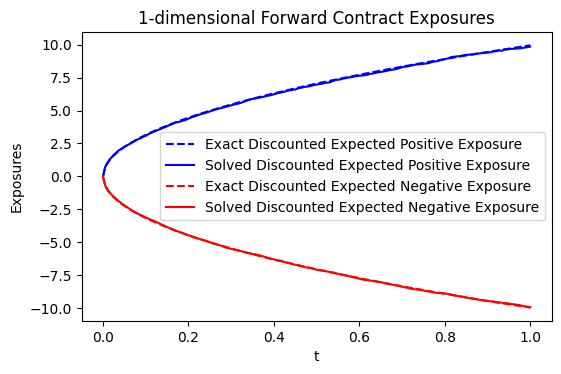

In [27]:
    fig = plt.figure(figsize=figsize(1.0))
    plt.plot(time_stamps,[0.0]+list(epe_exact),'b--',label='Exact Discounted Expected Positive Exposure')
    plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )

    plt.plot(time_stamps,[0.0]+list(ene_exact),'r--',label='Exact Discounted Expected Negative Exposure')
    plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')

    plt.xlabel('t')
    plt.ylabel('Exposures')
    plt.legend()
    plt.title(str(D) + '-dimensional Forward Contract Exposures')
    plt.savefig('Figures/Forward1D_exposures.pdf')
    plt.show()

array([0.        , 0.70522775, 0.99732974, 1.22145854, 1.41040042,
       1.57685516, 1.72733577, 1.86571163, 1.99450367, 2.11546305,
       2.22986477, 2.33867153, 2.44263083, 2.54233769, 2.63827414,
       2.7308378 , 2.82036016, 2.90712306, 2.9913661 , 3.07329623,
       3.15309449, 3.23091817, 3.30690729, 3.38118526, 3.45386207,
       3.52503733, 3.59479994, 3.66323107, 3.73040328, 3.79638377,
       3.86123378, 3.92500892, 3.98776123, 4.04953798, 4.1103832 ,
       4.17033761, 4.22943928, 4.2877233 , 4.34522268, 4.40196805,
       4.45798825, 4.51331035, 4.56795962, 4.62196016, 4.67533427,
       4.72810276, 4.78028647, 4.83190381, 4.88297295, 4.93351113,
       4.98353381, 5.03305705, 5.08209484, 5.13066145, 5.17877057,
       5.22643409, 5.2736645 , 5.32047311, 5.36687122, 5.41286954,
       5.45847759, 5.50370489, 5.54856214, 5.59305648, 5.63719745,
       5.68099395, 5.72445253, 5.76758153, 5.81038808, 5.85287932,
       5.8950624 , 5.93694326, 5.97852905, 6.01982511, 6.06083

In [34]:
np.max(np.abs(np.insert(epe_exact,0,0) - epe)), np.max(np.abs(np.insert(ene_exact,0,0) - ene))

(0.11805552279275133, 0.07297551241546074)

In [35]:
np.std(np.abs(np.insert(epe_exact,0,0) - epe)), np.std(np.abs(np.insert(ene_exact,0,0) - ene))

(0.027004360247442235, 0.01767027157560265)

In [204]:
model.save_model("models/Forward1D.pth")